In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [4]:
dataPath = '/Users/Torben/Code/breathmetrics/sample_data.mat'
myData=sp.io.loadmat(dataPath)
resp=np.squeeze(myData['resp'])
srate = np.squeeze(myData['srate'])

In [355]:
class bmObject:
    def __init__(self, resp, srate, dataType):
        self.resp = resp
        self.srate = srate
        self.dataType = dataType
        self.featureEstimationsComplete=0
        self.featuresManuallyEdited=0
        self.smoothedRespiration = []
        self.time = []
        self.baselineCorrectedRespiration = []
        
        self.inhalePeaks = []
        self.exhalePeaks = []
        self.peakInspiratoryFlows = []
        self.troughExpiratoryFlows = []
        
        self.inhaleOnsets = []
        self.exhaleOnsets = []
        
        # mean smoothing window is different for rodents and humans
        if dataType =='humanAirflow':
            self.smoothWinsize = 50

        elif dataType == 'humanBB':
            self.smoothWinsize = 50

        elif dataType == 'rodentAirflow':
            self.smoothWinsize = 10

        elif dataType == 'rodentThermocouple':
            self.smoothWinsize = 10
        else:
            print('todo error msg')
    
    
    # Preprocessing Methods
    
    # TODO
    #function validParams = checkClassInputs(Bm)


    
    def smoothResp(self):
        # de-noise data
        srateCorrectedSmoothedWindow = int(np.floor((srate/1000) * self.smoothWinsize))
        self.smoothedRespiration = self.running_mean(self.resp, srateCorrectedSmoothedWindow);
            
        # time is like fieldtrip. All events are indexed by point in
        # time vector.
        self.time = np.arange(0,len(self.resp)) / self.srate
            

    def correctRespirationToBaseline(self, method='simple', zScore=0, verbose=0):
        
        # default window size for sliding window mean is 60 seconds.
        swSize = 60; 
        
        detrendedResp=sp.signal.detrend(self.smoothedRespiration)
        respMean = self.smoothedRespiration - np.mean(self.smoothedRespiration)
    
        if method == 'simple':
            self.baselineCorrectedRespiration = respMean
            
        elif method == 'sliding':
            #for periodic drifts in data
            srateCorrectedSW = int(np.floor(self.srate * swSize));
        
            respSlidingMean=self.running_mean(self.smoothedRespiration, srateCorrectedSW);
                
            # subtract sliding mean from respiratory trace
            self.baselineCorrectedRespiration = self.smoothedRespiration - respSlidingMean
            
        if zScore == 1:
            self.baselineCorrectedRespiration = (self.baselineCorrectedRespiration - np.mean(self.baselineCorrectedRespiration)) / np.std(self.baselineCorrectedRespiration)
            
            
    def labelExtrema(self,simplify=0,verbose=0,customDecisionThreshold=0,swSizes=[]):
        # calls find extrema
        
        [putativePeaks, putativeTroughs] = self.findExtrema( customDecisionThreshold=customDecisionThreshold, swSizes=swSizes )
        
        # set nPeaks to nTroughs
        if simplify == 1:
            putativePeaks=putativePeaks[:len(putativeTroughs)]
            
        # The extrema represent the peak flow rates of inhales and exhales only in airflow recordings.
        if self.dataType == 'humanAirflow' or self.dataType == 'rodentAirflow':
            #indices of extrema
            self.inhalePeaks = putativePeaks
            self.exhaleTroughs = putativeTroughs

            # values of extrema
            self.peakInspiratoryFlows = self.baselineCorrectedRespiration[putativePeaks]
            self.troughExpiratoryFlows = self.baselineCorrectedRespiration[putativeTroughs]
            
            # In human breathing belt recordings, the peaks and troughs 
            # represent exhale and inhale onsets, respectively, because the
            # point where volume has maximized and instantaneously
            # decreases demarcates an exhale. This is unlike zero-crosses 
            # which demarcate breath onsets in airflow recordings.
            if self.dataType =='humanBB':
                
                self.inhaleOnsets = putativeTroughs;
                self.exhaleOnsets = putativePeaks;

            
            # In rodent thermocouple recordings, the peaks and troughs 
            # represent inhale and exhale onsets, respectively. Inhales
            # decrease the temperature in the nose and the onset is
            # demarcated by the first point this happens - the inflection
            # point of the peaks. Visa versa for exhales.
            elif self.dataType == 'rodentThermocouple':
                self.inhaleOnsets = putativePeaks;
                self.exhaleOnsets = putativeTroughs;
                
            
    # FEATURE EXTRACTION METHODS
    def findExtrema(self,customDecisionThreshold=0,swSizes=[]):
        
        resp=self.baselineCorrectedRespiration
        srateAdjust = self.srate/1000
        
        if len(swSizes)==0:
            if self.dataType == 'humanAirflow' or self.dataType == 'humanBB':
                srateAdjust = self.srate/1000
                swSizes = [int(np.floor(100*srateAdjust)),int(np.floor(300*srateAdjust)), int(np.floor(700*srateAdjust)), int(np.floor(1000*srateAdjust)), int(np.floor(5000*srateAdjust))]
                
            elif self.dataType == 'rodentAirflow' or self.dataType == 'rodentThermocouple':
                srateAdjust = self.srate/1000;
                swSizes = [int(np.floor(5*srateAdjust)), int(np.floor(10 * srateAdjust)), int(np.floor(20 * srateAdjust)), int(np.floor(50 * srateAdjust))];
        

        # pad end with zeros to include tail of data otherwise missed by big windows 
        padInd = min([len(resp)-1,max(swSizes)*2])
        flipInds=[len(resp)-padInd,len(resp)]
        lrFlipped = resp[flipInds[1]:flipInds[0]:-1]
        paddedResp = np.append(resp,lrFlipped)

        # initializing vector of all points where there is a peak or trough.
        swPeakVect = np.zeros([1, len(paddedResp)])
        swTroughVect = np.zeros([1, len(paddedResp)])

        # peaks and troughs must exceed this value. Sometimes algorithm finds mini peaks in flat traces
        peakThreshold = np.mean(resp) + np.std(resp) / 2
        troughThreshold = np.mean(resp) - np.std(resp) / 2

        # shifting window to be unbiased by starting point
        SHIFTS = np.arange(3)
        nWindows=len(swSizes)*len(SHIFTS)


        # find maxes in each sliding window, in each shift, and return peaks that are agreed upon by majority windows.

        # find extrema in each window of the data using each window size and offset
        for win in range(len(swSizes)):

            sw = swSizes[win];
            # cut off end of data based on sw size
            nIters  = int(np.floor(len(paddedResp) / sw)-1); 

            for shift in SHIFTS:
                # store index of max and min airflow in each window
                argmaxVect = np.zeros([1, nIters]);
                argminVect = np.zeros([1, nIters]);

                # shift starting point of sliding window to get unbiased maxes
                windowInit = int((sw - np.floor(sw / (shift+ 1))));

                # iterate over this window and find all maxima and minima
                windowIter=windowInit

                for i in range(nIters):
                    thisWindow = paddedResp[windowIter:windowIter + sw - 1]
                    maxVal = np.max(thisWindow)
                    maxInd = np.argmax(thisWindow)

                    # make sure peaks and troughs are real.
                    if maxVal > peakThreshold:
                        # index in window + location of window in original resp time
                        argmaxVect[0,i]= windowIter + maxInd-1

                    minVal = np.min(thisWindow)
                    minInd = np.argmin(thisWindow)
                    if minVal < troughThreshold:
                        # index in window + location of window in original resp time
                        argminVect[0,i]= windowIter+minInd-1

                    windowIter = windowIter + sw

                # add 1 to consensus vector at time index where peak was found by this window
                for i in range(len(argmaxVect[0])):
                    if argmaxVect[0,i] > 0:
                        timeIndex=int(argmaxVect[0,i])
                        swPeakVect[0,timeIndex] = swPeakVect[0,timeIndex]+1

                for i in range(len(argminVect[0])):
                    if argminVect[0,i] > 0:
                        timeIndex=int(argminVect[0,i])
                        swTroughVect[0,timeIndex] = swTroughVect[0,timeIndex]+1


        # find threshold that makes minimal difference in number of extrema found similar to idea of knee method of k-means clustering

        nPeaksFound = np.zeros([1, nWindows])
        nTroughsFound = np.zeros([1, nWindows])
        for threshold_ind in range(nWindows):
            nPeaksFound[0, threshold_ind] = int(np.sum(swPeakVect > threshold_ind))
            nTroughsFound[0, threshold_ind] = int(np.sum(swTroughVect > threshold_ind))

        bestPeakDiff = np.argmax(np.diff(nPeaksFound))
        bestTroughDiff = np.argmax(np.diff(nTroughsFound))

        if customDecisionThreshold > 0:
            bestDecisionThreshold = customDecisionThreshold
        else:
            bestDecisionThreshold = int(np.floor(np.mean([bestPeakDiff, bestTroughDiff])))


        # temporary peak inds. Each point where there is a real peak or trough
        peakInds = [i for i in range(swPeakVect.shape[1]) if swPeakVect[0,i] > bestDecisionThreshold]
        troughInds = [i for i in range(swTroughVect.shape[1]) if swTroughVect[0,i] > bestDecisionThreshold]
        
        # sometimes there are multiple peaks or troughs in series which shouldn't be possible. This loop ensures the series alternates peaks and troughs.

        # first we must find the first peak
        offByN = True;
        tri = 1;
        while offByN:
            if peakInds[tri] > troughInds[tri]:
                # remove this trough
                troughInds = troughInds[tri + 1:len(troughInds)]
            else:
                offByN=False;

        correctedPeaks = []
        correctedTroughs = []


        pki=1 # peak ind
        tri=1 # trough ind

        # variable to decide whether to record peak and trough inds.
        proceedCheck = 1

        # find peaks and troughs that alternate
        while pki <len(peakInds)-1 and tri < len(troughInds)-1:

            # time difference between peak and next trough
            peakTroughDiff = troughInds[tri] - peakInds[pki]

            # check if two peaks in a row
            peakPeakDiff = peakInds[pki+1] - peakInds[pki]

            if peakPeakDiff < peakTroughDiff:
                # if two peaks in a row, take larger peak
                nxtPk = np.argmax([paddedResp[peakInds[pki]], paddedResp[peakInds[pki+1]]])
                if nxtPk == 2:
                    # forget this peak. keep next one.
                    pki = pki+1
                else:
                    # forget next peak. keep this one.
                    peakInds = np.setdiff1d(peakInds, peakInds[pki+1])

                # there still might be another peak to remove so go back and check
                # again
                proceedCheck=0
            #end

            # if the next extrema is a trough, check for trough series
            if proceedCheck == 1:

                # check if trough is after this trough.
                troughTroughDiff = troughInds[tri + 1] - troughInds[tri]
                troughPeakDiff = peakInds[pki + 1] - troughInds[tri]

                if troughTroughDiff < troughPeakDiff:
                    # if two troughs in a row, take larger trough
                    nxtTr = np.argmin([paddedResp[troughInds[tri]], paddedResp[troughInds[tri + 1]]])
                    if nxtTr == 2:
                        # take second trough
                        tri = tri + 1
                    else:
                        # remove second trough
                        troughInds = np.setdiff1d(troughInds, troughInds[tri+1])

                    # there still might be another trough to remove so go back and 
                    # check again
                    proceedCheck=0

            # if both of the above pass we can save values
            if proceedCheck == 1:
                # if peaks aren't ahead of troughs
                if peakTroughDiff > 0:
                    #time_diff_pt = [time_diff_pt peak_trough_diff*srate_adjust];
                    correctedPeaks.append(peakInds[pki])
                    correctedTroughs.append(troughInds[tri])

                    # step forward
                    tri=tri+1;
                    pki=pki+1;
                else:
        #             # peaks got ahead of troughs. This shouldn't ever happen.
        #             disp('Peaks got ahead of troughs. This shouldnt happen.');
        #             disp(strcat('Peak ind: ', num2str(peakInds(pki))));
        #             disp(strcat('Trough ind: ', num2str(troughInds(tri))));
                    raise('unexpected error. stopping');

            proceedCheck=1;

        # remove any peaks or troughs in padding
        correctedPeaks = [i for i in correctedPeaks if i < len(resp)]
        correctedTroughs = [i for i in correctedTroughs if i < len(resp)]
        
        return correctedPeaks, correctedTroughs
        
        
        
        
        
    # bookkeeping methods
    def running_mean(self, x, N):
        startInd=int(np.floor(N/2))
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        unPadded=(cumsum[N:] - cumsum[:-N]) / N
        smoothedData=np.zeros([1,len(x)])
        smoothedData[0,startInd:startInd+len(unPadded)]=unPadded
        smoothedData=smoothedData[0]

        return smoothedData
    
    def printVars(self):
        print(self.data, self.srate, self.dataType)
    

In [356]:
bm=bmObject(resp,srate,'humanAirflow')
bm.smoothResp()
bm.correctRespirationToBaseline()

bm.labelExtrema()

In [11]:
zScore=1;
verbose=1;
bcMethod = 'sliding'

bm.smoothResp()
print(len(bm.baselineCorrectedRespiration))
print(len(resp))

print(len(bm.smoothedRespiration))
bm.correctRespirationToBaseline(bcMethod,zScore,verbose)
print(len(bm.baselineCorrectedRespiration))

660001
660001
660001
660001


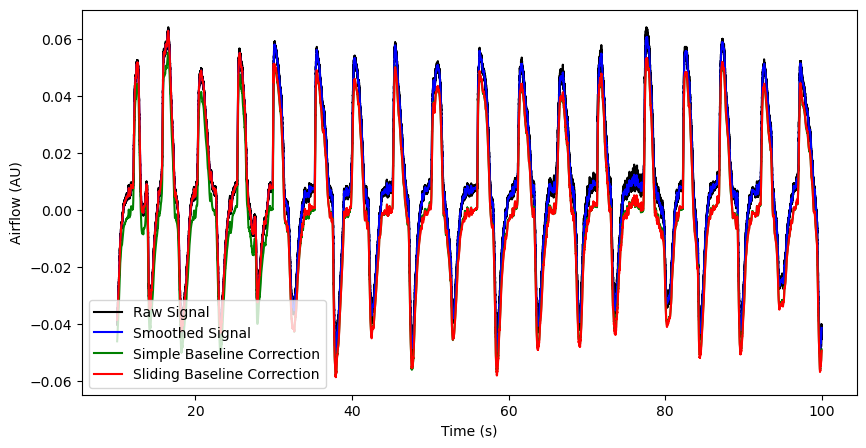

In [122]:
# compare resp trace using different smoothing methods

plotInds = np.arange(10000,100000)
bm.correctRespirationToBaseline('simple',0,verbose)
simpleBC=bm.baselineCorrectedRespiration

bm.correctRespirationToBaseline('sliding',0,verbose)
slidingBC=bm.baselineCorrectedRespiration

WIDTH_SIZE=10;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))
axs.plot(bm.time[plotInds],resp[plotInds],'k-',label='Raw Signal')
axs.plot(bm.time[plotInds],bm.smoothedRespiration[plotInds],'b-',label='Smoothed Signal')
axs.plot(bm.time[plotInds],simpleBC[plotInds],'g-',label='Simple Baseline Correction')
axs.plot(bm.time[plotInds],slidingBC[plotInds],'r-',label='Sliding Baseline Correction')
axs.legend()


axs.set_xlabel('Time (s)')
axs.set_ylabel('Airflow (AU)');

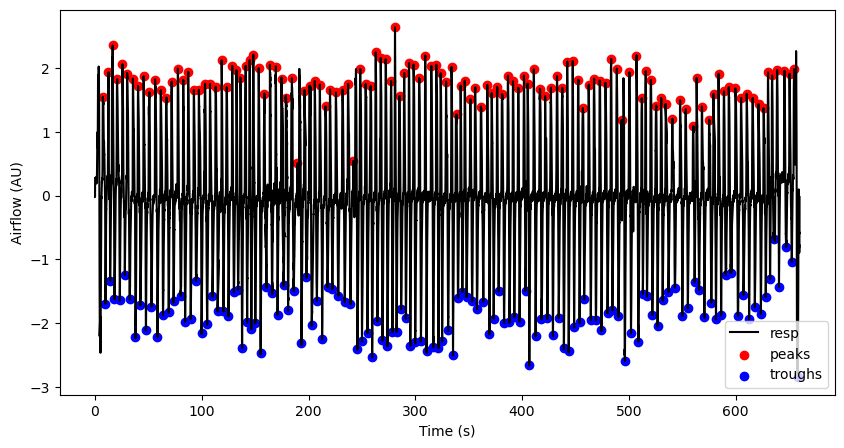

In [359]:
# do peaks and troughs look right?

WIDTH_SIZE=10;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))
axs.plot(bm.time,resp,'k-',label='resp')
axs.scatter(bm.time[bm.inhalePeaks],resp[bm.inhalePeaks],c='r',marker='o',label='peaks')
axs.scatter(bm.time[bm.exhaleTroughs],resp[bm.exhaleTroughs],c='b',marker='o',label='troughs')
# axs.scatter(bm.time[bm.inhaleOnsets],resp[bm.inhaleOnsets],c='r',marker='o',label='inhale onset')
# axs.scatter(bm.time[bm.exhaleOnsets],resp[bm.exhaleOnsets],c='b',marker='o',label='troughs')

axs.legend()


axs.set_xlabel('Time (s)')
axs.set_ylabel('Airflow (AU)');

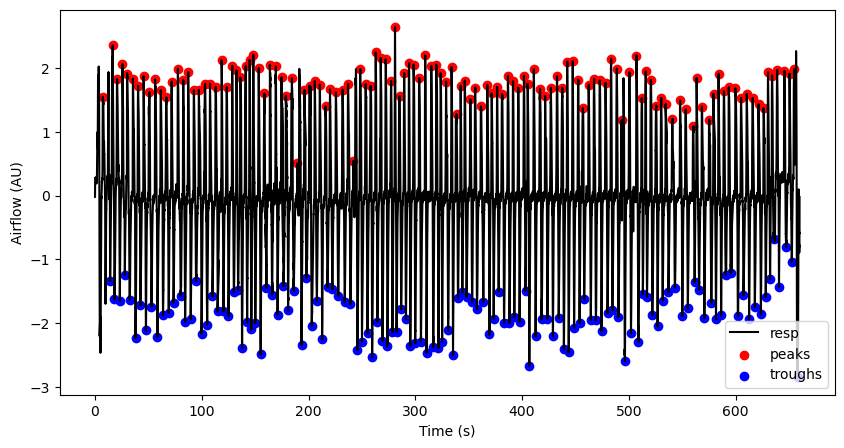

In [328]:
# do peaks and troughs look right?

WIDTH_SIZE=10;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))
axs.plot(bm.time,resp,'k-',label='resp')
axs.scatter(bm.time[correctedPeaks],resp[correctedPeaks],c='r',marker='o',label='peaks')
axs.scatter(bm.time[correctedTroughs],resp[correctedTroughs],c='b',marker='o',label='troughs')

axs.legend()


axs.set_xlabel('Time (s)')
axs.set_ylabel('Airflow (AU)');

In [ ]:

% find maxes in each sliding window, in each shift, and return peaks that
% are agreed upon by majority windows.

% find extrema in each window of the data using each window size and offset
for win = 1:length(swSizes)
    
    sw = swSizes(win);
    % cut off end of data based on sw size
    nIters  = floor(length(paddedResp) / sw)-1; 
    
    for shift = SHIFTS
        % store maxima and minima of each window
        argmaxVect = zeros(1, nIters);
        argminVect = zeros(1, nIters);
        
        %shift starting point of sliding window to get unbiased maxes
        windowInit = (sw - floor(sw / shift)) + 1;
         
        % iterate by this window size and find all maxima and minima
        windowIter=windowInit;
        for i = 1:nIters
            thisWindow = paddedResp(1, windowIter:windowIter + sw - 1);
            [maxVal,maxInd] = max(thisWindow);
            
            % make sure peaks and troughs are real.
            if maxVal > peakThreshold
                % index in window + location of window in original resp time
                argmaxVect(1,i)=windowIter + maxInd-1;
            end
            [minVal,minInd] = min(thisWindow);
            if minVal < troughThreshold
                % index in window + location of window in original resp time
                argminVect(1,i)=windowIter+minInd-1;
            end
            windowIter = windowIter + sw;
        end
        % add 1 to consensus vector
        swPeakVect(1, nonzeros(argmaxVect)) = ...
            swPeakVect(1,nonzeros(argmaxVect)) + 1;
        swTroughVect(1, nonzeros(argminVect)) = ...
            swTroughVect(1, nonzeros(argminVect)) + 1;
    end
end


% find threshold that makes minimal difference in number of extrema found
% similar idea to knee method of k-means clustering

nPeaksFound = zeros(1, nWindows);
nTroughsFound = zeros(1, nWindows);
for threshold_ind = 1:nWindows
    nPeaksFound(1, threshold_ind) = sum(swPeakVect > threshold_ind);
    nTroughsFound(1, threshold_ind) = sum(swTroughVect > threshold_ind);
end

[~,bestPeakDiff] = max(diff(nPeaksFound));
[~,bestTroughDiff] = max(diff(nTroughsFound));

if customDecisionThreshold>0
    bestDecisionThreshold = customDecisionThreshold;
else
    bestDecisionThreshold = floor(mean([bestPeakDiff, bestTroughDiff]));
end

% % temporary peak inds. Eacy point where there is a real peak or trough
peakInds = find(swPeakVect >= bestDecisionThreshold);
troughInds = find(swTroughVect >= bestDecisionThreshold);


% sometimes there are multiple peaks or troughs in series which shouldn't 
% be possible. This loop ensures the series alternates peaks and troughs.

% first we must find the first peak
offByN = 1;
tri = 1;
while offByN
    if peakInds(tri)> troughInds(tri)
        troughInds = troughInds(1, tri + 1:end);
    else
        offByN=0;
    end
end

correctedPeaks = [];
correctedTroughs = [];


pki=1; % peak ind
tri=1; % trough ind

% variable to decide whether to record peak and trough inds.
proceedCheck = 1; 

% find peaks and troughs that alternate
while pki <length(peakInds)-1 && tri<length(troughInds)-1
    
    % time difference between peak and next trough
    peakTroughDiff = troughInds(tri) - peakInds(pki);
    
    % check if two peaks in a row
    peakPeakDiff = peakInds(pki+1) - peakInds(pki);
    
    if peakPeakDiff < peakTroughDiff
        % if two peaks in a row, take larger peak
        [~, nxtPk] = max([paddedResp(peakInds(pki)), ...
            paddedResp(peakInds(pki+1))]);
        if nxtPk == 2
            % forget this peak. keep next one.
            pki = pki+1;
        else
            % forget next peak. keep this one.
            peakInds = setdiff(peakInds, peakInds(1, pki+1));
        end
        % there still might be another peak to remove so go back and check
        % again
        proceedCheck=0;
    end
    
    % if the next extrema is a trough, check for trough series
    if proceedCheck == 1
        
        % check if trough is after this trough.
        troughTroughDiff = troughInds(tri + 1) - troughInds(tri);
        troughPeakDiff = peakInds(pki + 1) - troughInds(tri);
        
        if troughTroughDiff < troughPeakDiff
            % if two troughs in a row, take larger trough
            [~, nxtTr] = min([paddedResp(troughInds(tri)), ...
                paddedResp(troughInds(tri + 1))]);
            if nxtTr == 2
                % take second trough
                tri = tri + 1;
            else
                % remove second trough
                troughInds = setdiff(troughInds, troughInds(1, tri + 1));
            end
            % there still might be another trough to remove so go back and 
            % check again
            proceedCheck=0;
        end
    end
    
    % if both of the above pass we can save values
    if proceedCheck == 1
        % if peaks aren't ahead of troughs
        if peakTroughDiff > 0
            %time_diff_pt = [time_diff_pt peak_trough_diff*srate_adjust];
            correctedPeaks = [correctedPeaks peakInds(pki)];
            correctedTroughs = [correctedTroughs troughInds(tri)];
            
            % step forward
            tri=tri+1;
            pki=pki+1;
        else
            % peaks got ahead of troughs. This shouldn't ever happen.
            disp('Peaks got ahead of troughs. This shouldnt happen.');
            disp(strcat('Peak ind: ', num2str(peakInds(pki))));
            disp(strcat('Trough ind: ', num2str(troughInds(tri))));
            raise('unexpected error. stopping');
        end
    end
    proceedCheck=1;
end

% remove any peaks or troughs in padding
correctedPeaks = correctedPeaks(correctedPeaks < length(resp));
correctedTroughs = correctedTroughs(correctedTroughs < length(resp));

end